### Importing libraries

In [1]:
#Basic Functionalities:
import os
import pandas as pd
import numpy as np

#PyTorch
import torchvision
import torch
import timm
from torch import optim
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms.functional import crop
from torch.utils.data import Dataset
from torch import nn
from torchinfo import summary
from fastai.torch_basics import *
from fastai.callback.hook import *

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt

# Misc.
import PIL
import cv2
import time
import warnings
from skimage.color import rgb2lab, lab2rgb
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Defining Datasets

In [2]:
class dataset(Dataset):
    def __init__(self, color_dir: str):
        self.color_images=[]

        for i in os.listdir(color_dir):
            self.color_images.append(color_dir+"/"+i)
            
        self.color_images.sort()
        
    def __len__(self):
        return len(self.color_images)

    def __getitem__(self,index):

        self.transforms = torchvision.transforms.Compose([
                torchvision.transforms.Resize((256, 256),  PIL.Image.BICUBIC),
            ])
        img = PIL.Image.open(self.color_images[index]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = torchvision.transforms.ToTensor()(img_lab)
        
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {"L":L, "ab":ab}


BATCH_SIZE=8

train_ds=dataset("../Dataset/ds/blackclover/colored/")
train_ds_2=dataset("../Dataset/ds/onepiece/colored/")
test_ds=dataset("../Dataset/ds/bukonohero/colored")

train_loader=torch.utils.data.DataLoader(train_ds,BATCH_SIZE)
train_loader_2=torch.utils.data.DataLoader(train_ds_2,BATCH_SIZE)
test_loader=torch.utils.data.DataLoader(test_ds,BATCH_SIZE)

### Misc. functions

In [3]:
def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.

    
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)


def visualize_resunet(model,loader: torch.utils.data.DataLoader = train_loader,size=(12,8)):
    plt.figure(figsize=size)
    i=1
    data=next(iter(loader))
     
    rand_ind=torch.randint(0,BATCH_SIZE-1,size=(1,)).item()
    
    bw=data["L"].to(device)
    color=data["ab"].to(device)

    result=model(bw).detach()
    
    full_img=lab_to_rgb(bw,color)
    result=lab_to_rgb(bw,result)

    while(i<6):
        plt.subplot(1,6,i)
        plt.axis(False)
        plt.imshow(result[i])
        i+=1



def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(25, 15))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### Model definition

In [4]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), n_in=n_input, pretrained=True, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

#### Custom LSTM

In [5]:
class NDIM_LSTM(nn.Module):
    
    def __init__(self,size):
        super().__init__()

        self.percent_ltr_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_ltr_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b1=nn.Parameter(torch.tensor(0.),requires_grad=False)

        self.percent_potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.percent_potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b2=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.potential_ltm_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.potential_ltm_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b3=nn.Parameter(torch.tensor(0.),requires_grad=False)
        
        self.output_stm_contri_stm_wt=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.output_stm_contri_input=nn.Parameter(torch.empty(size).normal_(mean=0.0,std=1.0),requires_grad=True)
        self.b4=nn.Parameter(torch.tensor(0.),requires_grad=False)

    def lstm_unit(self,input_value,long_memory,short_memory):
        
        long_remember_percent=torch.sigmoid((input_value*self.percent_ltr_input)+
                                            (self.percent_ltr_stm_wt*short_memory)+
                                            self.b1)
        
        potential_remember_percent=torch.sigmoid((input_value*self.percent_potential_ltm_input)+
                                                 (short_memory*self.percent_potential_ltm_stm_wt)+
                                                  self.b2)

        potential_memory = torch.tanh((short_memory * self.potential_ltm_stm_wt) + 
                                  (input_value * self.potential_ltm_input) + 
                                  self.b3)
        
        updated_long_memory = ((long_memory * long_remember_percent) + 
               (potential_remember_percent * potential_memory))

        output_percent = torch.sigmoid((short_memory * self.output_stm_contri_stm_wt) + 
                                       (input_value * self.output_stm_contri_input) + 
                                       self.b4)         
        
        updated_short_memory = torch.tanh(updated_long_memory) * output_percent

        return([updated_long_memory, updated_short_memory])

    def forward(self, input, long_memory=0, short_memory=0): 
        
        return self.lstm_unit(input,long_memory,short_memory)

#### ColorNet

In [6]:
class ColorNet(Module):
    def __init__(self,*layers):
        super().__init__()
        self.LSTM_bool=False
        self.layers = nn.ModuleList(layers)
        print(layers[3])
        
        self.ltm=torch.tensor(0).to(device)
        self.stm=torch.tensor(0).to(device)

        self.ltm.requires_grad=False
        self.stm.requires_grad=False

        self.res_ltm,self.res_stm =None ,None
        
        

    def init_lstm(self,size=(1024,8,8)):
        self.LSTM_bool=True
        self.lstm=NDIM_LSTM(size)
        print("LSTM initiated")

    def freeze_layers(self):
        for layer in self.layers.parameters():
            layer.requires_grad=False
        print("Layers Frozen")
    
    def forward(self,x):
        res=x

        for l in self.layers[0:3]:
            res.orig = x
            nres = l(res)
            #print(nres.shape)
            res.orig, nres.orig = None, None
            res = nres
                

        temp1=self.layers[3][0]
        temp2=self.layers[3][1]
        
        res.orig = x
        nres = temp1(res)
        res.orig, nres.orig = None, None
        res = nres

        
        #ltm,stm=self.lstm(res,self.ltm,self.stm)

        if(self.res_ltm is None):    
            self.res_ltm,self.res_stm = self.ltm,self.stm
            self.res_ltm.orig = x
            self.nres_ltm,self.nres_stm = self.lstm(res,self.ltm,self.stm)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            self.res_ltm.orig, self.nres_ltm.orig = None, None
            self.res_stm.orig, self.nres_stm.orig = None, None
            self.res_ltm = self.nres_ltm
            self.res_stm = self.nres_stm
        else:
            self.res_ltm,self.res_stm = self.res_ltm,self.res_stm
            self.res_ltm.orig = x
            self.nres_ltm,self.nres_stm = self.lstm(res,self.ltm,self.stm)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            self.res_ltm.orig, self.nres_ltm.orig = None, None
            self.res_stm.orig, self.nres_stm.orig = None, None
            self.res_ltm = self.nres_ltm
            self.res_stm = self.nres_stm
        

        res2=self.res_stm+res
        res2.orig = x
        nres = temp2(res2)
        res2.orig, nres.orig = None, None
        res2 = nres

        #print("SPLIT",res.shape)
        
        
        for l in self.layers[4:]:
            res2.orig = x
            nres = l(res2)
            #print(nres.shape)
            res2.orig, nres.orig = None, None
            res2 = nres
        
        return res2


#### GAN

In [7]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.data=data
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self, data=None):
        if(data is not None):
            self.L = data['L'].to(self.device)
            self.ab = data['ab'].to(self.device)
            self.fake_color = self.net_G(self.L)
            return self.fake_color
        else:
            self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(25, 15))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [8]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm_notebook(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward(retain_graph=True)
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

def finetune_model(model, train_dl, epochs, display_every=200):
    data = next(iter(test_loader)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm_notebook(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

#### Model init

Sequential(
  (0): ConvLayer(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
)
LSTM initiated
model initialized with norm initialization


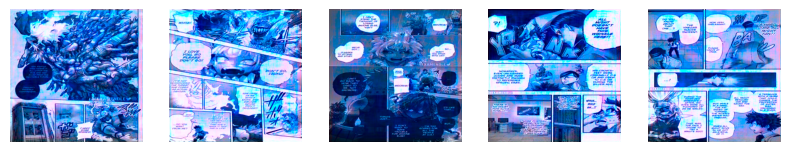

In [9]:
net_G=build_res_unet()
visualize_resunet(net_G,test_loader)

net_G=ColorNet(*net_G.layers)
net_G.init_lstm()

criterion = nn.L1Loss()     
net_G=net_G.to(device)
model = MainModel(net_G=net_G)

In [10]:
summary(model)

Layer (type:depth-idx)                                  Param #
MainModel                                               --
├─ColorNet: 1-1                                         --
│    └─ModuleList: 2-1                                  --
│    │    └─Sequential: 3-1                             11,170,240
│    │    └─BatchNorm2d: 3-2                            1,024
│    │    └─ReLU: 3-3                                   --
│    │    └─Sequential: 3-4                             9,438,720
│    │    └─UnetBlock: 3-5                              5,245,440
│    │    └─UnetBlock: 3-6                              3,180,544
│    │    └─UnetBlock: 3-7                              1,475,968
│    │    └─UnetBlock: 3-8                              380,736
│    │    └─PixelShuffle_ICNR: 3-9                      37,248
│    │    └─ResizeToOrig: 3-10                          --
│    │    └─MergeLayer: 3-11                            --
│    │    └─ResBlock: 3-12                              169,55

#### Checking model

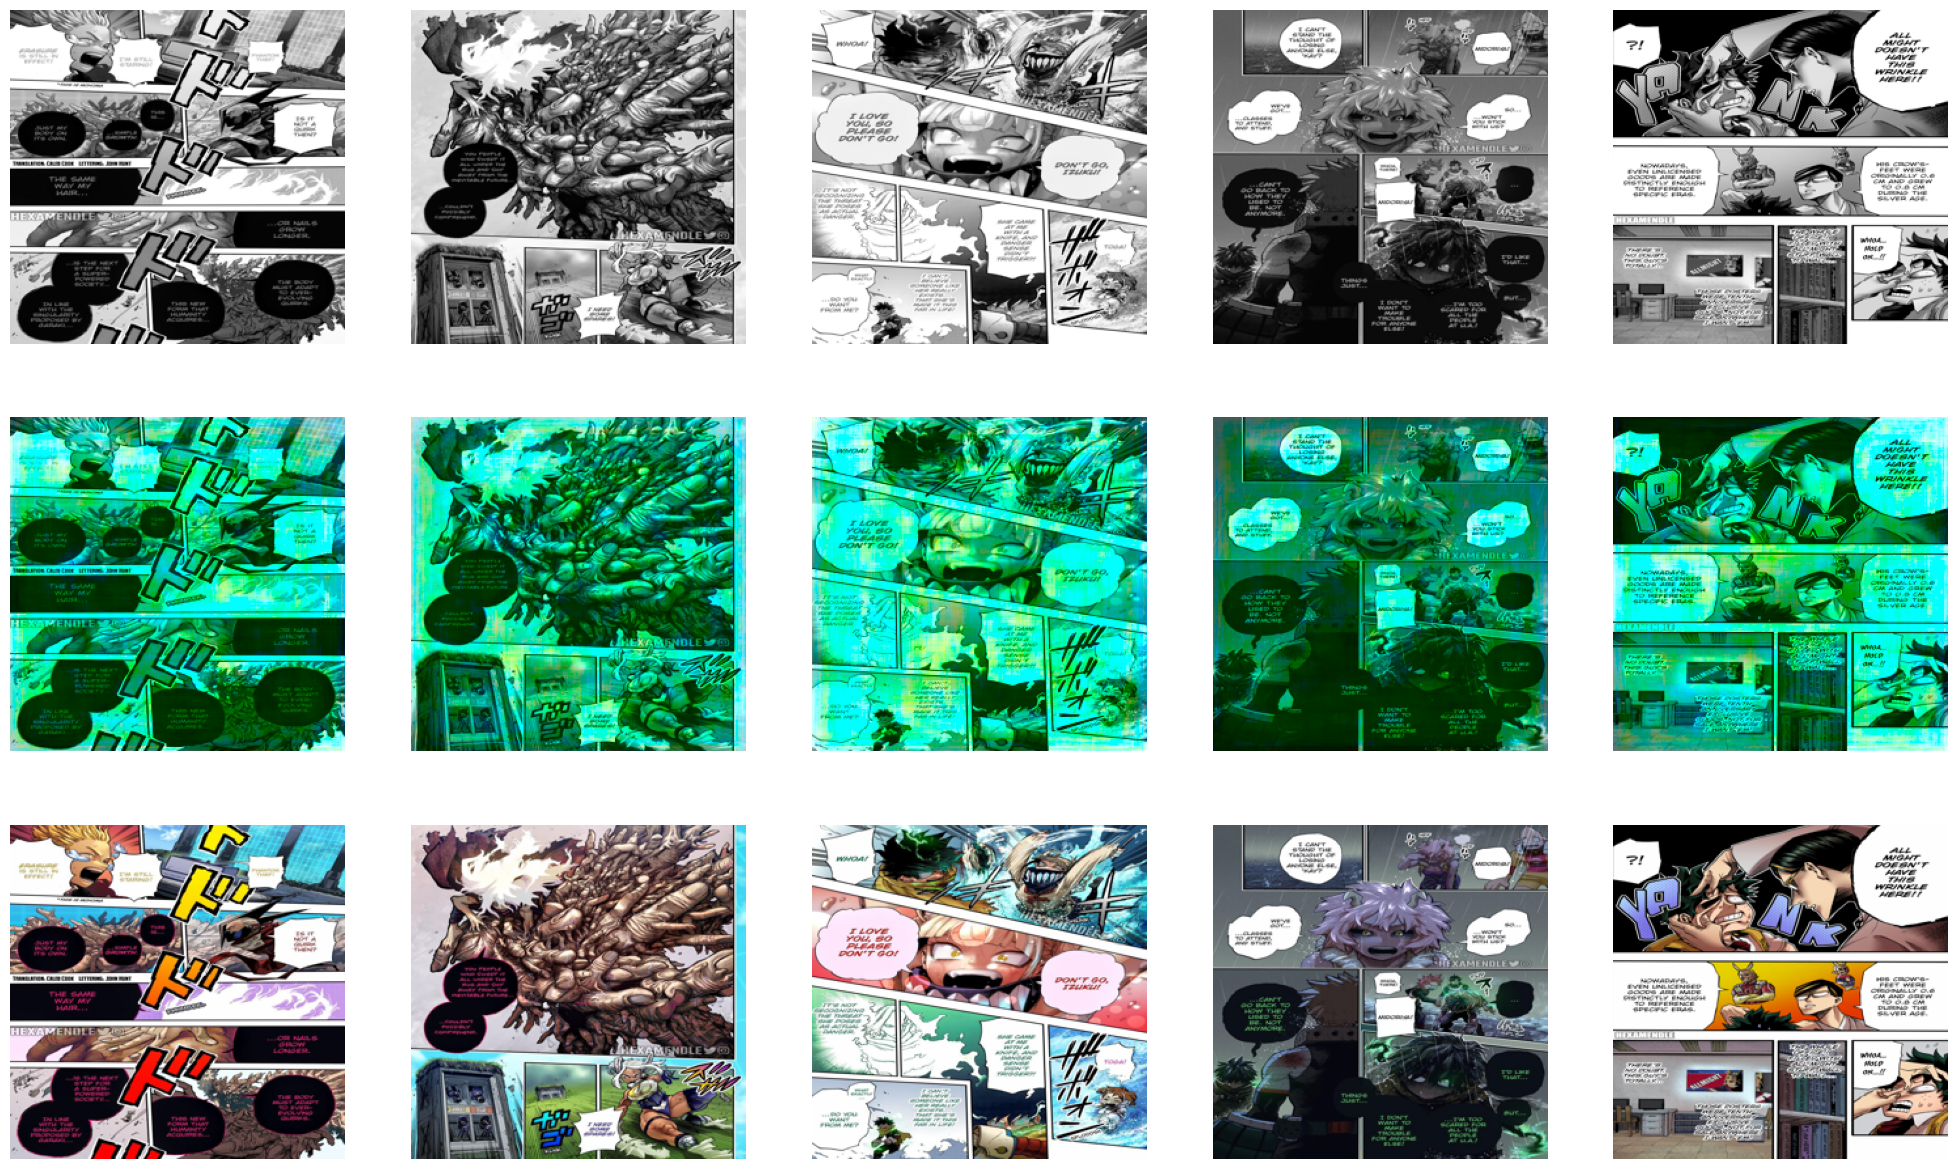

In [11]:
iter1=(iter(test_loader))
data1=next(iter1)
visualize(model,data1)

In [12]:
#data2=next(iter1)
#visualize(model,data2)

### Pretrainng Model

In [10]:
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_loader, opt, criterion, 20)

  0%|          | 0/134 [00:00<?, ?it/s]

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [256]] is at version 3; expected version 2 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

### Training with GAN (PHASE 1)

In [ ]:
finetune_model(model,train_loader,20,40)

In [ ]:
torch.save(model.net_G.state_dict(),"ColorNet_with_LSTM_FineTuned_PHASE1.pt")
torch.save(model.state_dict(),"ColorNet_incl_GAN_with_LSTM_FineTuned_PHASE1.pt")

#### Results after PHASE1

In [ ]:
data2=next(iter)
visualize(model,data2)

### Training with GAN (PHASE 2)

In [ ]:
finetune_model(model,train_loader2,20,40)

In [ ]:
torch.save(model.net_G.state_dict(),"ColorNet_with_LSTM_FineTuned_PHASE2.pt")
torch.save(model.state_dict(),"ColorNet_incl_GAN_with_LSTM_FineTuned_PHASE2.pt")

#### Results after PHASE2

In [ ]:
data2=next(iter)
visualize(model,data2)